# Поиск клиента с неоптимальными тарифами

### Введеине

#### Задачи:
    
    1. В связи с появлением на рынке нового конкурента со сравнительно низкими ценами и угрозой ухода клиентов необходимо проанализировать данные об использовании услуг виртуальной телефонии «Нупозвони» и найти активных клиентов, которые сэкономят, если перейдут на более дешевый или на более дорогой тариф
    2. Определить активных клиентов.
    3. Предложить отптимальный вариант по переводу активных клиентов на более оптимальный тариф с учетом минимизации потерь доходов.
    4. Подготовить презентационные и информационные материалы дял заказчика.

#### План:
Этап 1. Обработка полученных данных:
    
    *Приведение данных к соответствующему типу. 
    *Проверка на дубликаты, принятие решения по удалению. 
    *Проверка на пропуски, принятие решения по критичности. 
    *Проверка присутствия всех user_id в списке клиентов.
    *Проверка правильности заполнения поля total_call_duration. (подтверждение того, что данные в секундах)
    *Проверка длительности работы оператора (не более 12 часов в сутки).

Этап 2. Анализ данных:
    
    *Cоздание агрегированной таблицы по user_id, месяцам, direction, internal.
    *Поиск активных клиентов по количеству минут, количеству и типу звонков.
    *Добавление данных о тарифах и в полученный датасет. 
    *Добавление дат регистрации клиентов. Определение клиентов которые были не весь период. Сравнение дат с периодом активности. 
    *Просчет каждой строки по всем тарифам. Сравнение минимальных затрат по тарифу с текущими затартами.
    *Просчет дельты при разных вариантах перехода (например Если для пользователя с текущим тарифом А и выгодном тарифе С, просчитать варианты перехода с А на В и с А на С).
    *Предложить разные варианты и подходы для минимизации потери выручки.

Этап 3. Проверка гипотиз:
    
    *1-ая нулевая гипотиза: Переход с Текущего тарифа на Оптимальный тариф всех пользователей не повлечет значимого изменения в доходах «Нупозвони».
    *2-ая нулевая гипотиза: Переход части клиентов, а также частичное улучшение тарифа по выдвинутому предложению не повлечет значимого изменения в доходах «Нупозвони».


Этап 4. Выводы 
    
    Подведение итогов и определение оптимальных предложений.
    Подготовка презентации.
    Подготовка отчета с перечнем клиентов для изменения тарифа.
    Подготовка дашборда. 





Доп инфо:


ТАРИФЫ:

Ежемесячная плата за тариф:

- Тариф А — 5000 ₽,
- B — 2000 ₽,
- С — 1000 ₽.

**Входящие звонки** — бесплатны на всех тарифах,

**Исходящие звонки внутри сети** — бесплатны до 2000 минут в месяц на всех тарифах. Цена сверх лимита:

- A — 0.1 ₽/мин.,
- B — 0.15 ₽/мин.,
- C — 0.3 ₽/мин.

**Исходящие звонки, кроме внутренних:**

- A — 0.4 ₽/мин.,
- B — 0.5 ₽/мин.,
- C — 0.7 ₽/мин.

За каждого оператора клиент платит 100 ₽ в месяц на любом тарифе — дополнительно к стоимости тарифа и цене звонков.

## Обработка полученных данных:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import scipy.stats as st
import matplotlib.pyplot as plt

In [3]:
pth1 = '/datasets/telecom_clients.csv'
pth1_2 = 'telecom_clients.csv'
pth2 = '/datasets/telecom_dataset.csv'
pth2_2 = 'telecom_dataset.csv'

if os.path.exists(pth1):
    clients = pd.read_csv(pth1)
elif os.path.exists(pth1_2):
    clients = pd.read_csv(pth1_2)
else:
    print('Something is wrong')
if os.path.exists(pth2):
    data = pd.read_csv(pth2)
elif os.path.exists(pth2_2):
    data = pd.read_csv(pth2_2)
else:
    print('Something is wrong')

In [4]:
# clients.to_csv('telecom_clients.csv', index=False)
# data.to_csv('telecom_dataset.csv', index=False)

In [5]:
clients.info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 

In [6]:
print('Диапазон дат:',data['date'].min(), '-', data['date'].max())

Диапазон дат: 2019-08-02 00:00:00+03:00 - 2019-11-28 00:00:00+03:00


Имеем данные за 4 месяца. Неполныые месяцы считаем полными.

### Приведение данных к соответствующему типу

In [7]:
clients['date_start'] = clients['date_start'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data['date'] = data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data['month'] = data['date'].dt.month
data['minutes'] = (data['total_call_duration']/60).apply(np.ceil)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53902 non-null  int64         
 1   date                 53902 non-null  datetime64[ns]
 2   direction            53902 non-null  object        
 3   internal             53785 non-null  object        
 4   operator_id          45730 non-null  float64       
 5   is_missed_call       53902 non-null  bool          
 6   calls_count          53902 non-null  int64         
 7   call_duration        53902 non-null  int64         
 8   total_call_duration  53902 non-null  int64         
 9   month                53902 non-null  int64         
 10  minutes              53902 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 4.2+ MB


In [9]:
clients.head(2)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23


In [10]:
data.head(2)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,minutes
0,166377,2019-08-04,in,False,NaN,True,2,0,4,8,1.0
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,8,1.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53902 non-null  int64         
 1   date                 53902 non-null  datetime64[ns]
 2   direction            53902 non-null  object        
 3   internal             53785 non-null  object        
 4   operator_id          45730 non-null  float64       
 5   is_missed_call       53902 non-null  bool          
 6   calls_count          53902 non-null  int64         
 7   call_duration        53902 non-null  int64         
 8   total_call_duration  53902 non-null  int64         
 9   month                53902 non-null  int64         
 10  minutes              53902 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 4.2+ MB


In [12]:
data_copy = data.copy() 
# оставляем копию исходного фрейма
# с целью возможности дальнейшего обращения к сходным данным

Данные приведены к соответствующим типам.

### Проверка на дубликаты, принятие решения по удалению

In [13]:
clients.duplicated(keep=False).sum()

0

В таблице клиентов дубликатов нет

In [14]:
data['dup'] = data.duplicated(keep=False)
dup = data.query('dup == True')
len(dup)

9800

In [15]:
dup.head(20)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,minutes,dup
6,166377,2019-08-05,out,False,880020.0,True,8,0,50,8,1.0,True
8,166377,2019-08-05,out,False,880020.0,True,8,0,50,8,1.0,True
27,166377,2019-08-12,in,False,NaN,True,2,0,34,8,1.0,True
28,166377,2019-08-12,in,False,NaN,True,2,0,34,8,1.0,True
38,166377,2019-08-14,in,False,NaN,True,1,0,3,8,1.0,True
43,166377,2019-08-14,out,False,880026.0,False,10,1567,1654,8,28.0,True
44,166377,2019-08-14,out,False,880026.0,False,10,1567,1654,8,28.0,True
45,166377,2019-08-14,in,False,NaN,True,1,0,3,8,1.0,True
46,166377,2019-08-15,out,False,880026.0,False,11,1413,1473,8,25.0,True
51,166377,2019-08-15,out,False,880026.0,False,11,1413,1473,8,25.0,True


Удалим полные дубликаты (4900 строк)

In [16]:
data = data.drop_duplicates().reset_index(drop=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             48892 non-null  object        
 4   operator_id          41546 non-null  float64       
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
 9   month                49002 non-null  int64         
 10  minutes              49002 non-null  float64       
 11  dup                  49002 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 3.8+ MB


### Проверка присутствия всех user_id в списке клиентов

In [18]:
users1 = data['user_id'].unique()
users2 = clients['user_id'].unique()
def difference (list1, list2):
    new = []
    for i in list1:
        if i not in list2:
            new.append(i)
    print(new)
difference(users1,users2)

[]


Все пользователи присутствуют

### Проверка правильности заполнения поля total_call_duration. (подтверждение того, что данные в секундах). Проверка длительности работы оператора (не более 12 часов в сутки)

In [19]:
data.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration,month,minutes
count,49002.000000,41546.000000,49002.000000,49002.000000,49002.000000,49002.000000,49002.000000
mean,167294.892759,916523.315409,16.462777,866.282091,1156.558202,10.192380,19.791621
std,598.558965,21230.041008,63.604098,3775.503352,4451.473661,0.852065,74.185227
min,166377.000000,879896.000000,1.000000,0.000000,0.000000,8.000000,0.000000
25%,166782.000000,900790.500000,1.000000,0.000000,46.000000,10.000000,1.000000
50%,167158.000000,913938.000000,4.000000,37.000000,208.000000,10.000000,4.000000
75%,167819.000000,937708.000000,12.000000,570.000000,901.000000,11.000000,16.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000,11.000000,2770.000000


In [20]:
# максимум трудовой день у одного оператора может быть не больше чем:
12*60*60 # секунд

43200

In [21]:
too_long = data.query('total_call_duration > 86400')
print(len(too_long))
print(too_long['user_id'].unique())
print(too_long['operator_id'].unique())

26
[166582]
[885876.]


In [22]:
too_long

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,minutes,dup
6135,166582,2019-09-02,out,False,885876.0,False,1018,90095,108665,9,1812.0,False
6143,166582,2019-09-03,out,False,885876.0,False,1137,87700,109600,9,1827.0,False
6150,166582,2019-09-04,out,False,885876.0,False,863,91813,107524,9,1793.0,False
6157,166582,2019-09-05,out,False,885876.0,False,602,109032,120064,9,2002.0,False
6174,166582,2019-09-06,out,False,885876.0,False,584,87556,98711,9,1646.0,False
6192,166582,2019-09-09,out,False,885876.0,False,1138,121093,141930,9,2366.0,False
6200,166582,2019-09-10,out,False,885876.0,False,1053,80782,100139,9,1669.0,True
6208,166582,2019-09-11,out,False,885876.0,False,946,115057,132708,9,2212.0,False
6216,166582,2019-09-12,out,False,885876.0,False,696,125286,138643,9,2311.0,False
6227,166582,2019-09-13,out,False,885876.0,False,652,98748,111703,9,1862.0,False


Проанализировав данные можно заметить, что всего 3 пользователя и всего 6 операторов имеют превышающий установленный график работы. В сутках всего 86400 секунд. поэтому цифра точно не может быть больше.

Один пользователь и один оператор имею зашкаливающие показатели. Также у данного оператора нереальное для одних суток работы показатели количества звонков.
Передадим данную информацию заказчику и исключим данные значения из базы.

Пользователь 166582  (operator_id 885876). Вывести отдельно данные.

In [23]:
data.head(1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,minutes,dup
0,166377,2019-08-04,in,False,NaN,True,2,0,4,8,1.0,False


In [24]:
too_long = (data.groupby(['user_id','date','operator_id'], as_index=False)
        .agg(total_call_duration = ('total_call_duration','sum'),
            calls_count = ('calls_count','sum'))
        .query('total_call_duration > 86400')
        .groupby(['user_id','operator_id'], as_index=False)
        .agg(dates = ('date','nunique'),
#              operator_id = ('operator_id','unique'),
             calls_count = ('calls_count','sum'),
             avg_call_duration = ('total_call_duration','mean'))
)
too_long

,user_id,operator_id,dates,calls_count,avg_call_duration
0,166582,885876.0,27,39897,137450.074074
1,166582,885890.0,12,13447,93796.083333


In [25]:
data.query('user_id == 166582')['operator_id'].unique()

array([885890., 885876.,     nan, 925922.])

У пользователя два оперитора с зашкаливающими по продолжительности за 1 сутки показатилями продолжительности.\
Также есть неправильное определение оператора и один оператор с нормальными показателями.\
Что-то явно считается неправильно, передадим информацию клиенту отдельно по данному пользователю и исключим его из базы полностью, чтобы не исказить информацию.\
После этого посмотрим на операторов и пользователей превышабщих установленный в 12 часов.

In [26]:
data = data.query('user_id != 166582')

In [27]:
too_long = (data.groupby(['user_id','date','operator_id'], as_index=False)
        .agg(total_call_duration = ('total_call_duration','sum'),
            calls_count = ('calls_count','sum'))
        .query('total_call_duration > 43200')
        .groupby(['user_id','operator_id'], as_index=False)
        .agg(dates = ('date','nunique'),
#              operator_id = ('operator_id','unique'),
             calls_count = ('calls_count','sum'),
             avg_call_duration = ('total_call_duration','mean'))
)
too_long

,user_id,operator_id,dates,calls_count,avg_call_duration
0,167285,908640.0,2,3350,46630.5
1,167827,929424.0,1,1491,63253.0
2,167827,929428.0,2,4532,48428.5
3,168361,945278.0,1,227,61611.0


In [28]:
users_over_43200 = too_long["user_id"].unique()
data.query('user_id in @users_over_43200').groupby(['user_id','operator_id']).agg(calls_count=('calls_count','sum'))

calls_count
user_id operator_id             
167285  908640.0           14239
167827  929424.0            5229
        929426.0           11189
        929428.0           23754
168361  945074.0               3
        945274.0               1
        945278.0            4001
        945280.0            2399
        945282.0            2309
        945284.0            2071
        945286.0            6880
        945288.0            2209
        945290.0            3373
        945294.0            3368
        945296.0            2434
        945298.0            1313
        945302.0            6138
        945304.0            2576
        945308.0            1584
        945310.0            3311
        945312.0            2146
        945314.0            1763
        945316.0            2575
        945318.0            1839
        945320.0            2177
        945322.0            4775
        945324.0            2226
        965538.0             475
        965540.0             807
        965542.0             681
        965544.0            1277

Такие операторы есть, но их оставим, так как это вполне возможно в связи с автоматизированной системой и их не так много.\
Также перечислим их в отчете для инфомрации.

### Пропуски

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48282 entries, 0 to 49001
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48282 non-null  int64         
 1   date                 48282 non-null  datetime64[ns]
 2   direction            48282 non-null  object        
 3   internal             48172 non-null  object        
 4   operator_id          40937 non-null  float64       
 5   is_missed_call       48282 non-null  bool          
 6   calls_count          48282 non-null  int64         
 7   call_duration        48282 non-null  int64         
 8   total_call_duration  48282 non-null  int64         
 9   month                48282 non-null  int64         
 10  minutes              48282 non-null  float64       
 11  dup                  48282 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 4.1+ MB


In [30]:
data.query('(operator_id.isna())and(direction=="out")and(total_call_duration>0)and(is_missed_call==False)')#.head(50)#['user_id'].unique()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,minutes,dup
3732,166503,2019-09-26,out,False,NaN,False,1,213,220,9,4.0,False
3830,166503,2019-10-21,out,True,NaN,False,2,382,397,10,7.0,False
39783,168018,2019-11-05,out,False,NaN,False,1,978,984,11,17.0,False
39829,168018,2019-11-13,out,False,NaN,False,1,585,598,11,10.0,False
39868,168018,2019-11-26,out,False,NaN,False,1,229,246,11,5.0,False
45510,168252,2019-10-17,out,False,NaN,False,1,69,79,10,2.0,False
45519,168252,2019-10-18,out,False,NaN,False,1,170,177,10,3.0,True
45541,168252,2019-10-21,out,False,NaN,False,1,60,68,10,2.0,False
45562,168252,2019-10-23,out,False,NaN,False,1,81,100,10,2.0,False
45594,168252,2019-10-27,out,False,NaN,False,1,578,590,10,10.0,False


Пропуски в поле operator_id могут сказаться на итоговых финансовых результатах однако это никак не сказывается на выборе оптимального тарифа.\
Большая часть пропусков связана с пропущенными звонками или нулевой длительностью.\
С точки зрения исследования пропуски не существенны.

In [31]:
data.query('(internal.isna())and(direction=="out")')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,minutes,dup
19099,167016,2019-10-23,out,NaN,NaN,True,3,0,196,10,4.0,False
46717,168291,2019-11-28,out,NaN,NaN,True,3,0,93,11,2.0,False


Также пропуски присутствуют в столбце internal. Это платные звонки и они должны учитываться в расчетах. Однако пропуски всего в 6 минутах. Данные пропуски не существенны дял исследования из -за своего объема.

In [32]:
# ячейка тимлида:
(data
 .query('operator_id != operator_id')
 .groupby(['is_missed_call','direction','internal'])
 
 # агрегируем данные по количеству звонков и их длительности:
 .agg(call_count = ('calls_count','sum'),
      call_duration = ('total_call_duration','sum'))

 # считаем долю звонков:
 .assign(call_share = lambda x: x['call_count'] / x['call_count'].sum())
)

call_count  call_duration  call_share
is_missed_call direction internal                                       
False          in        False            636         324186    0.006387
                         True              10            900    0.000100
               out       False            311         179427    0.003123
                         True               8            893    0.000080
True           in        False          97501        1175556    0.979221
                         True             920          17969    0.009240
               out       False            132            150    0.001326
                         True              52            533    0.000522

## Анализ данных:

In [33]:
users_all = data['user_id'].unique() #все пользователи
print('всего пользователей', len(users_all))

всего пользователей 306


In [34]:
# создадим переменные с данными тарифов и прочих параметров дял использования в дальнейшем.
cost_of_operator = 100
limit = 2000

tarifs_out_calls = {
    'tariff_plan':['A', 'B', 'C'],
    'tariff_num':[1, 2, 3],
    'price':[0.4, 0.5, 0.7],
    'monthly':[5000, 2000, 1000],
    'overlimit_price':[0.1, 0.15, 0.3] }

tarifs_out = pd.DataFrame(tarifs_out_calls)
tarifs_out.set_index('tariff_plan', inplace=True)
tarifs_out

,tariff_num,price,monthly,overlimit_price
tariff_plan,,,,
A,1,0.4,5000,0.10
B,2,0.5,2000,0.15
C,3,0.7,1000,0.30


### Cоздание агрегированной таблицы по user_id, месяцам, direction, internal

In [35]:
agg_calls = (data
             .groupby(['month','user_id','direction','internal'], as_index=False)
             .agg({'minutes':'sum'})
             .query('(direction == "out")'))
agg_calls.head()

,month,user_id,direction,internal,minutes
1,8,166377,out,False,1337.0
2,8,166377,out,True,8.0
5,8,166391,out,True,1.0
9,8,166405,out,False,875.0
10,8,166405,out,True,1.0


In [36]:
# фуункция расчета стоимости оплаты по каждому тарифу.

def cost_of_outcalls(row, tarifs):
    sums = [] 
    length = len(tarifs) # Количество тарифов
    if row['internal'] == False:
        for i in range(length):
            sums.append(row['minutes'] * tarifs.iloc[i]['price']) 
    else:
        if (row['minutes'] - 2000) > 0:
            for i in range(length):
                sums.append((row['minutes']-2000) * tarifs.iloc[i]['overlimit_price'])
        else:
            sums = [0]*length
    return sums

costs = pd.DataFrame(agg_calls.apply(cost_of_outcalls, tarifs = tarifs_out, axis=1), columns=['costs'])
agg_calls[list(tarifs_out.index)] = pd.DataFrame(costs['costs'].tolist(), index= costs.index)
agg_calls.head()

,month,user_id,direction,internal,minutes,A,B,C
1,8,166377,out,False,1337.0,534.8,668.5,935.9
2,8,166377,out,True,8.0,0.0,0.0,0.0
5,8,166391,out,True,1.0,0.0,0.0,0.0
9,8,166405,out,False,875.0,350.0,437.5,612.5
10,8,166405,out,True,1.0,0.0,0.0,0.0


Цена за звонки по разным тарифам

In [37]:
# ячейка тимлида: посмотрим на тех клиентов, которые превысили лимит по внутренним исходящим - таких нет:
tmp = (data
             .groupby(['month','user_id','direction','internal'], as_index=False)
             .agg({'minutes':'sum'})
             .query('(direction == "out")'))
tmp[list(tarifs_out.index)] = pd.DataFrame(costs['costs'].tolist(), index= costs.index)
display(tmp.query('internal == True and minutes > 2000'))

# но в таблице выше есть траты по внутренним исходящим:
agg_calls.query('(internal == 1) and (A != 0)')  # вот так наверное по моей логике правильно

,month,user_id,direction,internal,minutes,A,B,C


,month,user_id,direction,internal,minutes,A,B,C


In [38]:
agg_calls = agg_calls.groupby(['user_id','month'], as_index=False).sum().drop(['minutes'], axis=1)

Подсчет операторов у каждого пользователя.

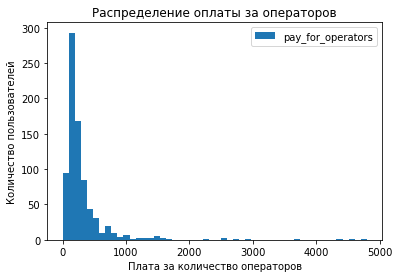

In [39]:
operators = (data
             .groupby(['user_id', 'month'], as_index=False)
             .agg({'operator_id':'nunique'})
             .rename(columns={'operator_id': 'operators'}))
operators['pay_for_operators'] = operators['operators'] * cost_of_operator
operators = operators.drop(['operators'], axis=1)
operators[['pay_for_operators']].plot(kind='hist', bins=50, title='Распределение оплаты за операторов')
plt.ylabel('Количество пользователей')
plt.xlabel('Плата за количество операторов');

In [40]:
operators['pay_for_operators'].unique()

array([ 500,  400,  200,  100,    0, 1000,  800,  300,  700, 1500, 1600,
       1300,  600, 1400, 1200, 1100, 2900, 1700,  900, 4400, 4800, 2700,
       3700, 4600, 2500, 2300], dtype=int64)

In [41]:
# К пользователям по месяцам с оплатой за операторов присоединяем оплату за звонки
data_consolidated = operators.merge(agg_calls, on=['user_id','month'], how='left')

In [42]:
# далее присоединяем текущий тарифный план
data_consolidated = data_consolidated.merge(clients[['user_id','tariff_plan']], on=['user_id'], how='left').fillna(0)

In [43]:
data_consolidated.head(3)

,user_id,month,pay_for_operators,A,B,C,tariff_plan
0,166377,8,500,534.8,668.5,935.9,B
1,166377,9,400,727.2,909.0,1272.6,B
2,166377,10,500,681.6,852.0,1192.8,B


In [44]:
# Функция для расчета полной ежемесячной оплаты за тариф
def totals(df, tarifs):
    columns = ['user_id','month','tariff_plan'] #создаем список с названиями столбцов итоговой таблицы
    for item in tarifs.index: # перебираем тарифы
        # для каждого пользователя суммируем оплату за операторов, за минту, абонентскую плату. 
        df['%s' % item] = df['pay_for_operators'] + df[item] + tarifs['monthly'][item]
        columns.append('%s' % item) # добавляем названия тарифов в список столбцов 
    total = df[columns] #выводим столбцы
    return total

In [45]:
total = totals(data_consolidated, tarifs_out)

In [46]:
total.head()

,user_id,month,tariff_plan,A,B,C
0,166377,8,B,6034.8,3168.5,2435.9
1,166377,9,B,6127.2,3309.0,2672.6
2,166377,10,B,6181.6,3352.0,2692.8
3,166377,11,B,6053.2,3216.5,2543.1
4,166391,8,C,5200.0,2200.0,1200.0


In [47]:
# Функция для возвращения сумммы за тариф по названию тарифа
def now(row):
    return row[row['tariff_plan']]

In [48]:
total['sum_now'] = total.apply(now, axis=1)

In [49]:
total['tariff_plan_best'] = total[tarifs_out.index].idxmin(axis=1) # создаём столбец с названием оптимального тарифа
total['sum_best'] = total[tarifs_out.index].min(axis=1) # возвращаем сумму по названию тарифа

In [50]:
total.head()

,user_id,month,tariff_plan,A,B,C,sum_now,tariff_plan_best,sum_best
0,166377,8,B,6034.8,3168.5,2435.9,3168.5,C,2435.9
1,166377,9,B,6127.2,3309.0,2672.6,3309.0,C,2672.6
2,166377,10,B,6181.6,3352.0,2692.8,3352.0,C,2692.8
3,166377,11,B,6053.2,3216.5,2543.1,3216.5,C,2543.1
4,166391,8,C,5200.0,2200.0,1200.0,1200.0,C,1200.0


In [51]:
# Создаём агрегированную таблицу с суммами за весь период и делаем расчет оптимального тарифа
total_agg = total.groupby(['user_id'], as_index=False).agg({'tariff_plan':'last', 
                                                            'A': 'sum',
                                                            'B': 'sum',
                                                            'C': 'sum',
                                                            'sum_now': 'sum' })
total_agg['tariff_plan_best'] = total_agg[tarifs_out.index].idxmin(axis=1)
total_agg['sum_best'] = total_agg[tarifs_out.index].min(axis=1) 
total_agg.head()

,user_id,tariff_plan,A,B,C,sum_now,tariff_plan_best,sum_best
0,166377,B,24396.8,13046.0,10344.4,13046.0,C,10344.4
1,166391,C,20400.0,8400.0,4400.0,4400.0,C,4400.0
2,166392,C,20800.0,8800.0,4800.0,4800.0,C,4800.0
3,166399,C,15300.0,6300.0,3300.0,3300.0,C,3300.0
4,166405,B,28891.2,18514.0,17759.6,18514.0,C,17759.6


In [52]:
total_good_tarif = total.copy()
# делаемкопию таблицы, пока не провели её усечение и обработку

In [53]:
# ячейка тимлида:
total_not_stable = (total
 .groupby('user_id')
 .agg(num_month = ('month','nunique'),
      tariff_plan = ('tariff_plan','unique'),
      num_tariff_plan_best = ('tariff_plan_best','nunique'),
      tariff_plan_best = ('tariff_plan_best','unique'))
 .query('num_tariff_plan_best > 1')
)
total_not_stable

,num_month,tariff_plan,num_tariff_plan_best,tariff_plan_best
user_id,,,,
166405,4,[B],2,"[C, B]"
167011,2,[C],2,"[C, B]"
167285,2,[A],2,"[C, B]"
167626,2,[A],2,"[B, A]"
168062,2,[A],2,"[C, B]"
168187,2,[A],2,"[C, B]"
168252,2,[A],2,"[C, B]"
168361,2,[A],2,"[B, A]"


In [54]:
total_users_not_stable = total_not_stable.index
total_users_not_stable

Int64Index([166405, 167011, 167285, 167626, 168062, 168187, 168252, 168361], dtype='int64', name='user_id')

In [55]:
total = total.query('user_id not in @total_users_not_stable')
total_agg = total_agg.query('user_id not in @total_users_not_stable')

<div style="border:solid steelblue 3px; padding: 5px">
    
При таком подходе мы можем получить такую ситуацию, когда клиент находится между двумя тарифами по оптимальности. Т.е. его объем услуг еще не стабилизировался. Возможно, что такому клиенту пока рано предлагать какой-либо тариф, так как в следующем месяце все может поменяться и ему наоборот будет невыгоден тариф, который предлагаем.
    
Уберем этих клиентов из дальнейшей проверки в отдельный список и в конце по ним представлю отдельную справку.

### Определение активных клиентов

In [56]:
# Сводная таблица по пользователям по каждому месяцу (с суммой затрат)
user_month_sum = total.pivot_table(index='user_id', columns='month', values='sum_now')
user_month_sum.columns = ['aug','sep','oct','nov']
user_month_sum.head()

,aug,sep,oct,nov
user_id,,,,
166377,3168.5,3309.0,3352.0,3216.5
166391,1200.0,1100.0,1000.0,1100.0
166392,1200.0,1200.0,1200.0,1200.0
166399,1100.0,1100.0,1100.0,NaN
166406,3620.0,3148.5,3143.0,2603.0


In [57]:
# Примем за активных пользователей тех, кто в ноябре совершал платыне действия.
users_active = user_month_sum.reset_index().query('nov.notna()')['user_id'].unique()
print('Всего активных пользователей:',len(users_active),'из', len(users_all))

Всего активных пользователей: 255 из 306


Также проанализируем количество исходящих минут

In [58]:
out_minutes = (data
               .query('direction == "out"')
               .groupby(['user_id','month'], as_index=False)['minutes'].sum())
out_minutes = out_minutes.pivot_table(index='user_id', columns='month', values='minutes')

In [59]:
out_minutes['minute_sum'] = out_minutes.sum(axis=1)
out_minutes.describe().style.format('{:.1f}')

month,8,9,10,11,minute_sum
count,49.0,118.0,167.0,178.0,221.0
mean,348.2,763.7,1239.1,1383.1,2535.3
std,883.4,2496.3,4607.7,5807.2,8817.5
min,0.0,1.0,0.0,0.0,0.0
25%,3.0,16.2,15.5,29.5,41.0
50%,28.0,96.0,183.0,228.5,377.0
75%,198.0,368.5,736.5,844.2,1474.0
max,5358.0,21324.0,52072.0,72502.0,94037.0


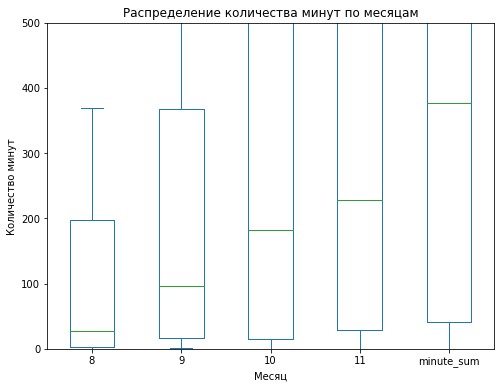

In [60]:
out_minutes.sort_values(by='minute_sum').reset_index(drop=True).plot(kind='box', ylim=(0,500), title='Распределение количества минут по месяцам', figsize=(8,6))
plt.ylabel('Количество минут')
plt.xlabel('Месяц');

Можно заметить, что медианное количество минут намного меньше среднего, а первый квартиль не превышает 30 минут, а значит очень много малоактивных пользователей.<br>
Поэтому будем считать всех малоактивных - активными.<br>
А неактивными будут только те, которые не совершал платных действий в ноябре.<br>
Далее изучаем только активных пользователей (users_active)

In [61]:
total = total.query('user_id in @users_active') # по месяцам
total_agg = total_agg.query('user_id in @users_active') # за весь период

### Отбор пользователей с оптимальным/неоптимальным тарифом

In [62]:
# найдём неоптимальных пользователей у которых тариф не совпадает с оптимальным в последнем месяце.
users_not_optimal = list(total.query('~user_id.duplicated(keep="last")').query('tariff_plan != tariff_plan_best')['user_id'].unique())
len(users_not_optimal)

120

In [63]:
# найдём пользователей у которых неоптимален период в целом.
users_not_optimal_agg = list(total_agg.query('tariff_plan != tariff_plan_best')['user_id'].unique())
len(users_not_optimal_agg)

120

In [64]:
# удалим из users_not_optimal_agg пользователей из users_not_optimal (у которых последний месяц неоптимален)
users_stabilased = users_not_optimal_agg.copy()
for user in users_not_optimal:
    if user in users_stabilased:
        users_stabilased.remove(user)
users_stabilased

[]

По данным пользователям users_not_optimal и users_not_optimal_agg можно менять тариф для оптимизации расходов.
Однако, пользователи у которых последний месяц является оптимальным нет необходимости трогать, так как они принесли прибыль больше чем могли бы при этом оптимизировав расходы в последнем месяце. Их покажем отдельной таблицей справочно в выводах.

Пользователи, которые в последнем месяце имели неоптимальный тариф наоборот можно разделить на тех, которые в целом неоптимальны и тех, кто неоптимален только в последний месяц. Их тоже нужно разделить.

In [65]:
users_optimal_agg = list(users_active)
for user in users_not_optimal_agg:
    users_optimal_agg.remove(user)
len(users_optimal_agg)

135

In [66]:
users_destabilased = []
users_optimal = users_optimal_agg.copy()
for user in users_optimal_agg:
    if user in users_not_optimal:
        users_destabilased.append(user)
        users_optimal.remove(user)
len(users_destabilased)

0

In [67]:
len(users_optimal)

135

Пользователи users_destabilased в целом пользуются оптимальным тарифом, однако в последнем месяце тариф был невыгоден.\
Справочно укажем это в выводах.

### Анализ активных пользователей с неоптимальным тарифом в последнем месяце

Список пользователей с неоптимальным тарифом (в финальном месяце тариф не оптимален) в переменной users_not_optimal.<br>

In [68]:
# Выборка по неоптимальным пользователям
# за последний месяц
total_bad_tarif = total.query('user_id in @users_not_optimal').sort_values(by=['user_id','month'])
total_bad_tarif = total_bad_tarif.query('~user_id.duplicated(keep="last")').reset_index(drop=True)
# за весь период
total_bad_tarif_agg = total_agg.query('user_id in @users_not_optimal').sort_values(by=['user_id']).reset_index(drop=True)

In [69]:
display(total_bad_tarif.head(4))
display(total_bad_tarif_agg.head(2))

,user_id,month,tariff_plan,A,B,C,sum_now,tariff_plan_best,sum_best
0,166377,11,B,6053.2,3216.5,2543.1,3216.5,C,2543.1
1,166406,11,B,5522.4,2603.0,1764.2,2603.0,C,1764.2
2,166407,11,A,5856.4,2870.5,1898.7,5856.4,C,1898.7
3,166428,11,B,5100.0,2100.0,1100.0,2100.0,C,1100.0


,user_id,tariff_plan,A,B,C,sum_now,tariff_plan_best,sum_best
0,166377,B,24396.8,13046.0,10344.4,13046.0,C,10344.4
1,166406,B,23791.6,12514.5,9960.3,12514.5,C,9960.3


In [70]:
# Создадим словарь соответствия названия тарифа и номера
# Тарифы располагаем по уменьшению объемов и стоимости.
# Чем больше цифра, тем дешевле тариф и меньше минут включено.

tariff_dict = tarifs_out[['tariff_num']].T.to_dict('records')[0]
tariff_dict

{'A': 1, 'B': 2, 'C': 3}

In [71]:
# Создадим обратный словарь
tariff_dict_rev = {}
for keys, num in tariff_dict.items():
    tariff_dict_rev[num]= keys
tariff_dict_rev

{1: 'A', 2: 'B', 3: 'C'}

In [72]:
# заменим назваине тарифа на номер (цифру)
total_bad_tarif['tariff_plan'] = total_bad_tarif['tariff_plan'].map(tariff_dict)
total_bad_tarif['tariff_plan_best'] = total_bad_tarif['tariff_plan_best'].map(tariff_dict)
total_bad_tarif.head(2)

,user_id,month,tariff_plan,A,B,C,sum_now,tariff_plan_best,sum_best
0,166377,11,2,6053.2,3216.5,2543.1,3216.5,3,2543.1
1,166406,11,2,5522.4,2603.0,1764.2,2603.0,3,1764.2


#### Дельта текущего и оптимельного тарифов

#### По количеству пользователей

In [73]:
total_bad_tarif['diff'] = total_bad_tarif['tariff_plan_best'] - total_bad_tarif['tariff_plan']

In [74]:
tarif_delta = total_bad_tarif.groupby(['tariff_plan','diff'])[['user_id']].count().reset_index()
tarif_delta.columns = ['tariff_plan_now', 'delta', 'users']
tarif_delta['tariff_plan_now'] = tarif_delta['tariff_plan_now'].map(tariff_dict_rev)
tarif_delta

,tariff_plan_now,delta,users
0,A,2,25
1,B,1,94
2,C,-1,1


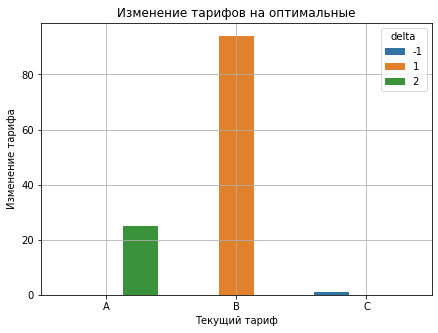

In [75]:
plt.figure(figsize=(7, 5))
ax = sns.barplot(x='tariff_plan_now', y='users', hue='delta', data=tarif_delta) 
plt.title('Изменение тарифов на оптимальные')
plt.grid(True)
plt.ylabel('Изменение тарифа')
plt.xlabel('Текущий тариф');

Большинство пользователей используют тариф более дорогой, чем им нужно.\
Самая неоптимальная группа на тарифе B и с него целесообразно перейти на C (94 пользователя).\
С тарифа A выгодно перейти на тариф C (25 пользователей).\
Только одному пользователю необходимо перейти на более дорогой тариф (с тарифа C на тариф B).

#### В денежном выражении

In [76]:
total_bad_tarif

,user_id,month,tariff_plan,A,B,C,sum_now,tariff_plan_best,sum_best,diff
0,166377,11,2,6053.2,3216.5,2543.1,3216.5,3,2543.1,1
1,166406,11,2,5522.4,2603.0,1764.2,2603.0,3,1764.2,1
2,166407,11,1,5856.4,2870.5,1898.7,5856.4,3,1898.7,2
3,166428,11,2,5100.0,2100.0,1100.0,2100.0,3,1100.0,1
4,166485,11,2,6864.8,4206.0,3888.4,4206.0,3,3888.4,1
...,...,...,...,...,...,...,...,...,...,...
115,168562,11,2,5100.0,2100.0,1100.0,2100.0,3,1100.0,1
116,168578,11,2,5000.0,2000.0,1000.0,2000.0,3,1000.0,1
117,168579,11,2,5200.0,2200.0,1200.0,2200.0,3,1200.0,1
118,168583,11,2,5200.0,2200.0,1200.0,2200.0,3,1200.0,1


In [77]:
total_bad_tarif['sum_diff'] = total_bad_tarif['sum_best'] - total_bad_tarif['sum_now']

In [78]:
sum_delta = total_bad_tarif.groupby(['tariff_plan','diff'])[['sum_diff']].sum().reset_index()
sum_delta['sum_diff'] = sum_delta['sum_diff']*-1
sum_delta.columns = ['tariff_plan_now', 'delta', 'Потенциальный убыток']
sum_delta['tariff_plan_now'] = sum_delta['tariff_plan_now'].map(tariff_dict_rev)
sum_delta

,tariff_plan_now,delta,Потенциальный убыток
0,A,2,96657.1
1,B,1,85785.4
2,C,-1,937.2


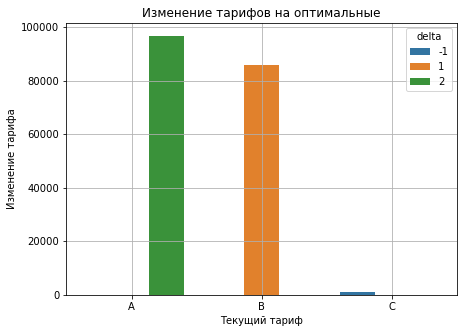

In [79]:
plt.figure(figsize=(7, 5))
ax = sns.barplot(x='tariff_plan_now', y='Потенциальный убыток', hue='delta', data=sum_delta) 
plt.title('Изменение тарифов на оптимальные')
plt.grid(True)
plt.ylabel('Изменение тарифа')
plt.xlabel('Текущий тариф');

Можно заметить, что максимальный убыток даст перевод пользователей с тарифа А на тариф С.\
В данной ситуации стоит рассмотреть перевод этих пользователей с А на В.\
С точки зрения выбора пользователей для перевода необходимо понять политику компании в данном вопросе.\
Более подробный расчет будет далее.

#### Проанализируем изменения по сумме

##### Предположим, что следующий месяц будет таким же как ноябрь.

In [80]:
total_bad_tarif['sum_now_cumsum'] = total_bad_tarif['sum_now'].cumsum()
total_bad_tarif['sum_best_cumsum'] = total_bad_tarif['sum_best'].cumsum()
total_bad_tarif['% превышения расходов над оптимальными'] = total_bad_tarif['sum_now_cumsum']/total_bad_tarif['sum_best_cumsum']*100

In [81]:
# Создадим датафрейм с расчетами доходов. 
sums_compare = pd.DataFrame({
    'Вариант': [],
    'Доход при текущих тарифах всего': [],
    'Доход при оптимизации': [], 
    'Разница': []})
sums_compare

,Вариант,Доход при текущих тарифах всего,Доход при оптимизации,Разница


In [82]:
a={'Вариант':'Вариант_Все(максимум)',
   'Доход при текущих тарифах всего':total_bad_tarif['sum_now'].sum(),
   'Доход при оптимизации':total_bad_tarif['sum_best'].sum(),
   'Разница':total_bad_tarif['sum_best'].sum()-total_bad_tarif['sum_now'].sum()}
sums_compare = sums_compare.append(a, ignore_index=True)
sums_compare

# print('Доход при текущих тарифах всего', total_bad_tarif['sum_now'].sum(),'\n',
#       'Доход при оптимальных тарифах всего', total_bad_tarif['sum_best'].sum(),'\n',
#       'Разница', round(total_bad_tarif['sum_best'].sum()-total_bad_tarif['sum_now'].sum()))

C:\Users\Strel\AppData\Local\Temp\ipykernel_3832\919378410.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sums_compare = sums_compare.append(a, ignore_index=True)


,Вариант,Доход при текущих тарифах всего,Доход при оптимизации,Разница
0,Вариант_Все(максимум),381573.9,198194.2,-183379.7


In [83]:
display(total_bad_tarif.head(2))

,user_id,month,tariff_plan,A,B,C,sum_now,tariff_plan_best,sum_best,diff,sum_diff,sum_now_cumsum,sum_best_cumsum,% превышения расходов над оптимальными
0,166377,11,2,6053.2,3216.5,2543.1,3216.5,3,2543.1,1,-673.4,3216.5,2543.1,126.479494
1,166406,11,2,5522.4,2603.0,1764.2,2603.0,3,1764.2,1,-838.8,5819.5,4307.3,135.107840


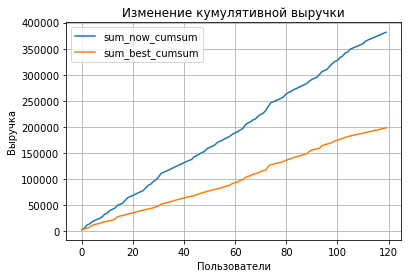

In [84]:
total_bad_tarif[['sum_now_cumsum','sum_best_cumsum']].plot(grid=True, xlabel='Пользователи', ylabel='Выручка', title='Изменение кумулятивной выручки');

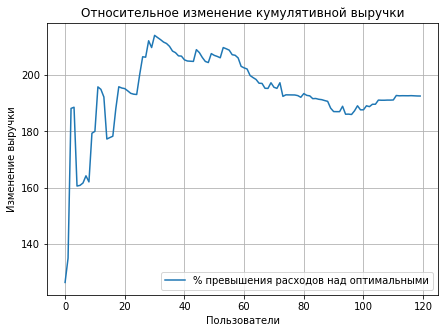

In [85]:
total_bad_tarif[['% превышения расходов над оптимальными']].plot(grid=True, xlabel='Пользователи', ylabel='Изменение выручки', title='Относительное изменение кумулятивной выручки', figsize=(7, 5));

##### Предположим, что в исследуемый период у всех НЕОПТИМАЛЬНЫХ пользователей был бы оптимальный тариф.

In [86]:
# a={'Вариант':'Вариант_Все(4 месяца)',
#    'Доход при текущих тарифах всего':total_bad_tarif_agg['sum_now'].sum(),
#    'Доход при оптимизации':total_bad_tarif_agg['sum_best'].sum(),
#    'Разница':total_bad_tarif_agg['sum_best'].sum()-total_bad_tarif_agg['sum_now'].sum()}
# sums_compare = sums_compare.append(a, ignore_index=True)
# sums_compare
print(' Доход при текущих тарифах всего', round(total_bad_tarif_agg['sum_now'].sum()),'\n',
      'Доход при оптимальных тарифах всего', round(total_bad_tarif_agg['sum_best'].sum()),'\n',
      'Разница', round(total_bad_tarif_agg['sum_best'].sum()-total_bad_tarif_agg['sum_now'].sum()))

 Доход при текущих тарифах всего 1038679 
 Доход при оптимальных тарифах всего 510247 
 Разница -528432


In [87]:
total_bad_tarif_agg['sum_now_cumsum'] = total_bad_tarif_agg['sum_now'].cumsum()
total_bad_tarif_agg['sum_best_cumsum'] = total_bad_tarif_agg['sum_best'].cumsum()
total_bad_tarif_agg['% превышения расходов над оптимальными'] = total_bad_tarif_agg['sum_now_cumsum']/total_bad_tarif_agg['sum_best_cumsum']*100

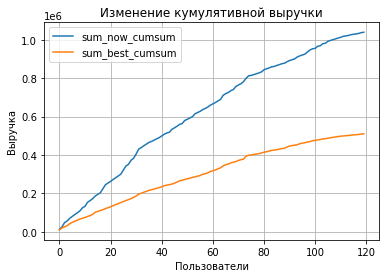

In [88]:
total_bad_tarif_agg[['sum_now_cumsum','sum_best_cumsum']].plot(grid=True, xlabel='Пользователи', ylabel='Выручка', title='Изменение кумулятивной выручки');

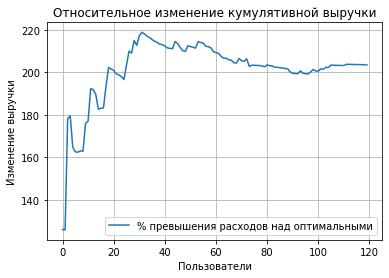

In [89]:
total_bad_tarif_agg[['% превышения расходов над оптимальными']].plot(grid=True, xlabel='Пользователи', ylabel='Изменение выручки', title='Относительное изменение кумулятивной выручки');

По всем полученным данным видно, что полный перевод пользователей на оптимальный тариф крайне сильно скажется на прибыль компании.

#### Колебание убытка по пользователям (при переводе на оптимальный тариф)

In [90]:
total_bad_tarif.head(2)

,user_id,month,tariff_plan,A,B,C,sum_now,tariff_plan_best,sum_best,diff,sum_diff,sum_now_cumsum,sum_best_cumsum,% превышения расходов над оптимальными
0,166377,11,2,6053.2,3216.5,2543.1,3216.5,3,2543.1,1,-673.4,3216.5,2543.1,126.479494
1,166406,11,2,5522.4,2603.0,1764.2,2603.0,3,1764.2,1,-838.8,5819.5,4307.3,135.107840


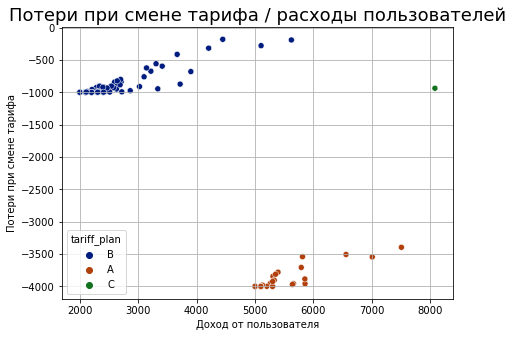

In [91]:
total_bad_tarif['tariff_plan'] = total_bad_tarif['tariff_plan'].map(tariff_dict_rev)
plt.figure(figsize=(7, 5))
ax = sns.scatterplot(x='sum_now', y='sum_diff', hue='tariff_plan',palette='dark', data=total_bad_tarif)
plt.grid(True)
plt.xlabel('Доход от пользователя')
plt.ylabel('Потери при смене тарифа')
plt.title('Потери при смене тарифа / расходы пользователей', size=18);

Проанализировав график можно отметить, что есть пользователи, котрые принесут не очень большой убыток при этом их достаточно много, а платят мало.\
Несколько пользователей платят очень много при этом убыток будет средний. (их точно нужно переводить)\
И есть группа , которая платит в районе 6000 при этом при переводе их на оптимальный тариф убыток будет по 3,5-4 тысячи. ( думаю что эту группу лучше не трогать, либо трогать, с частичным улучшением условий).\
Посмотрим, как будет выглядеть этот график, если предложить частичное улучшение условий.

### Просчет дельты при разных вариантах перехода (например Если для пользователя с текущим тарифом А и выгодном тарифе С, просчитать варианты перехода с А на В и с А на С).

#### Вариант 1. Изменим улучшение тарифа с 2ух шагов на 1

In [92]:
total_bad_tarif['diff_1'] = total_bad_tarif['diff'].mask(total_bad_tarif['diff'] == 2, 1)

In [93]:
total_bad_tarif['tariff_plan'] = total_bad_tarif['tariff_plan'].map(tariff_dict)

In [94]:
total_bad_tarif['tariff_plan_1'] = total_bad_tarif['tariff_plan'] + total_bad_tarif['diff_1']

In [95]:
total_bad_tarif['tariff_plan_1'] = total_bad_tarif['tariff_plan_1'].map(tariff_dict_rev)

In [96]:
# Функция для возвращения сумммы за тариф по НОМЕРУ тарифа
def sum_by_name(row,num):
    return row[row['tariff_plan_%s' %num]]

In [97]:
total_bad_tarif['sum_1'] = total_bad_tarif.apply(sum_by_name, num=1, axis=1)
total_bad_tarif['sum_diff_1'] = total_bad_tarif['sum_1'] - total_bad_tarif['sum_now']

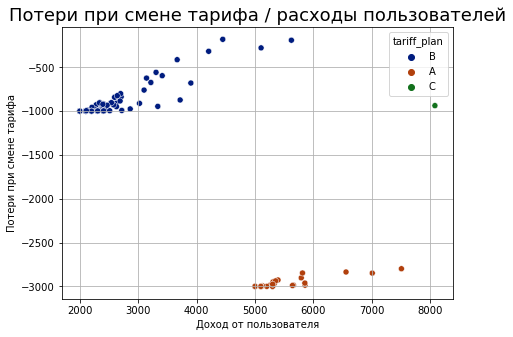

In [98]:
total_bad_tarif['tariff_plan'] = total_bad_tarif['tariff_plan'].map(tariff_dict_rev)
plt.figure(figsize=(7, 5))
ax = sns.scatterplot(x='sum_now', y='sum_diff_1',hue='tariff_plan',palette='dark', data=total_bad_tarif)
plt.grid(True)
plt.xlabel('Доход от пользователя')
plt.ylabel('Потери при смене тарифа')
plt.title('Потери при смене тарифа / расходы пользователей', size=18); #Потери при смене тарифа / расходы пользователей
total_bad_tarif['tariff_plan'] = total_bad_tarif['tariff_plan'].map(tariff_dict)

Ситуация сильно не поменялась. Только группа которая могла принести недополучение прибыли 3,5-4 тысячи, теперь принесёт недополучение 2,5-3 тысячи. Таким образом, стоит хорошо обдумать стоит ли их трогать.

In [99]:
a={'Вариант':'Вариант_Все(1шаг)',
   'Доход при текущих тарифах всего':total_bad_tarif['sum_now'].sum(),
   'Доход при оптимизации':total_bad_tarif['sum_1'].sum(),
   'Разница':total_bad_tarif['sum_1'].sum()-total_bad_tarif['sum_now'].sum()}
sums_compare = sums_compare.append(a, ignore_index=True)
sums_compare

# print(' Доход при текущих тарифах всего', round(total_bad_tarif['sum_now'].sum()),'\n',
#       'Доход при переводе всех на 1 шаг', round(total_bad_tarif['sum_1'].sum()),'\n',
#       'Разница', round(total_bad_tarif['sum_1'].sum()-total_bad_tarif['sum_now'].sum()))

C:\Users\Strel\AppData\Local\Temp\ipykernel_3832\1510109899.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sums_compare = sums_compare.append(a, ignore_index=True)


,Вариант,Доход при текущих тарифах всего,Доход при оптимизации,Разница
0,Вариант_Все(максимум),381573.9,198194.2,-183379.7
1,Вариант_Все(1шаг),381573.9,220965.6,-160608.3


Изначальный вариант\
 Разница всего -191877

Разница между двумя подходами небольшая.

#### Вариант 2 для минимизации потери выручки.

В данном варианте не будем трогать пользователей которые приносят не очень много денег при этом сильно переплачивают.\
А клиентов, от которых потеряем не более 2,5 тысяч добавим в список изменений.

In [100]:
total_bad_tarif = total_bad_tarif.drop(['month','sum_now_cumsum','sum_best_cumsum'], axis=1)

In [101]:
total_bad_tarif.head(2)

,user_id,tariff_plan,A,B,C,sum_now,tariff_plan_best,sum_best,diff,sum_diff,% превышения расходов над оптимальными,diff_1,tariff_plan_1,sum_1,sum_diff_1
0,166377,2,6053.2,3216.5,2543.1,3216.5,3,2543.1,1,-673.4,126.479494,1,C,2543.1,-673.4
1,166406,2,5522.4,2603.0,1764.2,2603.0,3,1764.2,1,-838.8,135.107840,1,C,1764.2,-838.8


In [102]:
# Функция для создания смещения по тарифной сетке (для варианта 2):
def condition_2(row):
    if row['sum_diff']>-2500:
        return row['diff_1']
    else:
        return 0    

In [103]:
total_bad_tarif

,user_id,tariff_plan,A,B,C,sum_now,tariff_plan_best,sum_best,diff,sum_diff,% превышения расходов над оптимальными,diff_1,tariff_plan_1,sum_1,sum_diff_1
0,166377,2,6053.2,3216.5,2543.1,3216.5,3,2543.1,1,-673.4,126.479494,1,C,2543.1,-673.4
1,166406,2,5522.4,2603.0,1764.2,2603.0,3,1764.2,1,-838.8,135.107840,1,C,1764.2,-838.8
2,166407,1,5856.4,2870.5,1898.7,5856.4,3,1898.7,2,-3957.7,188.138898,1,B,2870.5,-2985.9
3,166428,2,5100.0,2100.0,1100.0,2100.0,3,1100.0,1,-1000.0,188.555981,1,C,1100.0,-1000.0
4,166485,2,6864.8,4206.0,3888.4,4206.0,3,3888.4,1,-317.6,160.632995,1,C,3888.4,-317.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,168562,2,5100.0,2100.0,1100.0,2100.0,3,1100.0,1,-1000.0,192.619816,1,C,1100.0,-1000.0
116,168578,2,5000.0,2000.0,1000.0,2000.0,3,1000.0,1,-1000.0,192.657726,1,C,1000.0,-1000.0
117,168579,2,5200.0,2200.0,1200.0,2200.0,3,1200.0,1,-1000.0,192.600602,1,C,1200.0,-1000.0
118,168583,2,5200.0,2200.0,1200.0,2200.0,3,1200.0,1,-1000.0,192.544174,1,C,1200.0,-1000.0


In [104]:
# применим сдвиг и рассчитаем все параметры.
total_bad_tarif['diff_2'] = total_bad_tarif.apply(condition_2, axis=1)
total_bad_tarif['tariff_plan_2'] = (total_bad_tarif['tariff_plan'] + total_bad_tarif['diff_2']).map(tariff_dict_rev)
total_bad_tarif['sum_2'] = total_bad_tarif.apply(sum_by_name, num=2, axis=1)
total_bad_tarif['sum_diff_2'] = total_bad_tarif['sum_2'] - total_bad_tarif['sum_now']

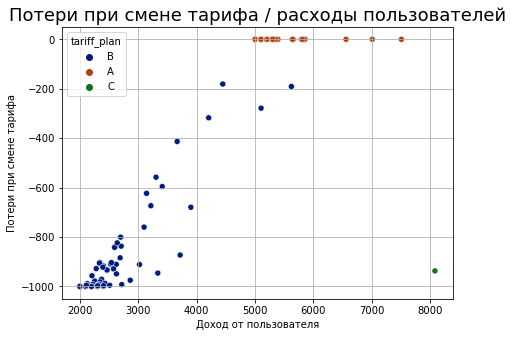

In [105]:
total_bad_tarif['tariff_plan'] = total_bad_tarif['tariff_plan'].map(tariff_dict_rev)
plt.figure(figsize=(7, 5))
ax = sns.scatterplot(x='sum_now', y='sum_diff_2',hue='tariff_plan',palette='dark', data=total_bad_tarif)
plt.grid(True)
plt.xlabel('Доход от пользователя')
plt.ylabel('Потери при смене тарифа')
plt.title('Потери при смене тарифа / расходы пользователей', size=18)
total_bad_tarif['tariff_plan'] = total_bad_tarif['tariff_plan'].map(tariff_dict)

In [106]:
a={'Вариант':'Вариант_Частично',
   'Доход при текущих тарифах всего':total_bad_tarif['sum_now'].sum(),
   'Доход при оптимизации':total_bad_tarif['sum_2'].sum(),
   'Разница':total_bad_tarif['sum_2'].sum()-total_bad_tarif['sum_now'].sum()}
sums_compare = sums_compare.append(a, ignore_index=True)
sums_compare

# print(' Доход при текущих тарифах всего', round(total_bad_tarif['sum_now'].sum()),'\n',
#       'Доход при переводе с учетом 2варианта', round(total_bad_tarif['sum_2'].sum()),'\n',
#       'Разница', round(total_bad_tarif['sum_2'].sum()-total_bad_tarif['sum_now'].sum()))

C:\Users\Strel\AppData\Local\Temp\ipykernel_3832\3071640028.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sums_compare = sums_compare.append(a, ignore_index=True)


,Вариант,Доход при текущих тарифах всего,Доход при оптимизации,Разница
0,Вариант_Все(максимум),381573.9,198194.2,-183379.7
1,Вариант_Все(1шаг),381573.9,220965.6,-160608.3
2,Вариант_Частично,381573.9,294851.3,-86722.6


При данном условии уже заметно значительное уменьшение потерь потенциального дохода при оптимизации.

### Визуализация результатов

In [107]:
sums_compare_c=sums_compare.copy()
sums_compare=sums_compare_c.copy()

In [108]:
sums_compare
sums_compare = sums_compare.set_index('Вариант')
sums_compare

,Доход при текущих тарифах всего,Доход при оптимизации,Разница
Вариант,,,
Вариант_Все(максимум),381573.9,198194.2,-183379.7
Вариант_Все(1шаг),381573.9,220965.6,-160608.3
Вариант_Частично,381573.9,294851.3,-86722.6


In [109]:
sums_compare = sums_compare.stack().reset_index()
sums_compare.columns = ['Вариант','Тип','Сумма']

In [110]:
sums_compare

,Вариант,Тип,Сумма
0,Вариант_Все(максимум),Доход при текущих тарифах всего,381573.9
1,Вариант_Все(максимум),Доход при оптимизации,198194.2
2,Вариант_Все(максимум),Разница,-183379.7
3,Вариант_Все(1шаг),Доход при текущих тарифах всего,381573.9
4,Вариант_Все(1шаг),Доход при оптимизации,220965.6
5,Вариант_Все(1шаг),Разница,-160608.3
6,Вариант_Частично,Доход при текущих тарифах всего,381573.9
7,Вариант_Частично,Доход при оптимизации,294851.3
8,Вариант_Частично,Разница,-86722.6


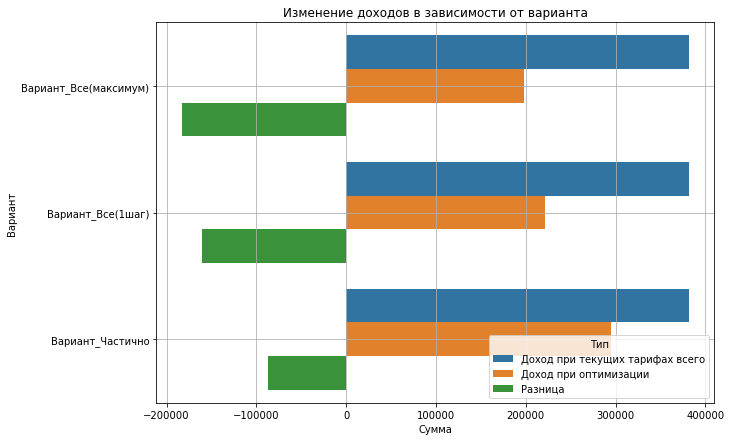

In [111]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(y='Вариант', x='Сумма',hue='Тип', data = sums_compare)
plt.title('Изменение доходов в зависимости от варианта')
plt.grid(True)
plt.show()

В каждом варианте видно, что доходы уменьшаются.
При этом вариант с наименьшей потерей прибыли - это частичная оптимизация тарифов (только у тех пользователей из-за которых теряем не много и тех, которые приносят очень большой текущий доход).

## Проверка гипотиз


In [112]:
# Требуемый уровень значимости 
alpha = 0.05

### Нулевая гипотиза: Переход с Текущего тарифа на Оптимальный тариф всех пользователей не повлечет  изменения в доходах «Нупозвони»
Альтернативная гипотиза: Переход с Текущего тарифа на Оптимальный тариф всех пользователей повлечет изменения в доходах «Нупозвони»

In [113]:
total_good_tarif = total_good_tarif.query('user_id in @users_optimal')#.query('~user_id.duplicated(keep="last")')
optimal_sums = total_good_tarif['sum_now']
len(optimal_sums)

359

In [114]:
first = pd.concat([total_bad_tarif['sum_now'], optimal_sums])
second= pd.concat([total_bad_tarif['sum_best'], optimal_sums])

results = st.mannwhitneyu(first, second)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  3.6401744976573925e-06
Отвергаем нулевую гипотезу: разница статистически значима


### Нулевая гипотиза: Переход части клиентов по выдвинутому предложению (Вариант 2) не повлечет изменения в доходах «Нупозвони».
Альтернативная гипотиза: Переход части клиентов по выдвинутому предложению (Вариант 2) повлечет изменения в доходах «Нупозвони».

In [115]:
first = pd.concat([total_bad_tarif['sum_now'], optimal_sums])
second= pd.concat([total_bad_tarif['sum_2'], optimal_sums])

results = st.mannwhitneyu(first, second)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.000716321715238511
Отвергаем нулевую гипотезу: разница статистически значима


В обоих случаях изменения статистически значимы и повлекут изменения в доходах «Нупозвони».

## Выводы

Для проверки оптимальности тарифа были отобраны активные пользователи. Критерием стало наличие платных действий в ноябре.
Всего активных пользователей: 261 из 307.<br>

Большинство пользователей используют тариф более дорогой, чем им нужно.<br>
Самая неоптимальная группа на тарифе B и с него целесообразно перейти на C (94 пользователя).<br>
С тарифа A выгодно перейти на тариф C (25 пользователей).<br>
Только одному пользователю необходимо перейти на более дорогой тариф (с тарифа C на тариф B).<br>

Максимальный убыток даст перевод пользователей с тарифа А на тариф В или С.<br>

Вариант полного перевода всех пользователей на оптимальный тариф крайне неоптимален. Недополучение выручки будет -183380.<br>
Потери можно сократить, если не трогать пользователей которые приносят не очень много денег при этом сильно переплачивают, а клиентов, от которых потеряем не более 2,5 тысяч добавим в список изменений.<br>
    Доход при текущих тарифах за ноябрь 381574.<br>
    Доход при переводе с учетом варианта 2 (частично) 294851.<br>
    Разница всего -86723.<br>

При всех проверенных изменениях будет существенное изменение в уровне выручки.

## Материалы
Данные выгрузки: https://disk.yandex.ru/i/-sSonvZPdOL_DQ <br>
Презентация: https://disk.yandex.ru/i/PtrXlMcEbaoEBQ <br>
Дашборд: (тут не требуется, приложу в следующем разделе).

In [116]:
users_optimal

[166391,
 166392,
 166482,
 166487,
 166511,
 166520,
 166585,
 166604,
 166619,
 166636,
 166649,
 166658,
 166669,
 166677,
 166688,
 166691,
 166692,
 166708,
 166717,
 166726,
 166782,
 166803,
 166812,
 166833,
 166836,
 166939,
 166940,
 166973,
 166974,
 166983,
 166985,
 166997,
 167003,
 167016,
 167031,
 167035,
 167052,
 167059,
 167079,
 167102,
 167109,
 167112,
 167139,
 167150,
 167162,
 167180,
 167188,
 167199,
 167200,
 167235,
 167238,
 167242,
 167246,
 167272,
 167277,
 167286,
 167364,
 167397,
 167412,
 167455,
 167456,
 167466,
 167471,
 167506,
 167532,
 167533,
 167534,
 167545,
 167575,
 167599,
 167630,
 167644,
 167646,
 167650,
 167653,
 167664,
 167715,
 167721,
 167727,
 167742,
 167744,
 167747,
 167756,
 167781,
 167792,
 167805,
 167816,
 167829,
 167852,
 167870,
 167888,
 167906,
 167923,
 167927,
 167936,
 167948,
 167958,
 167976,
 167994,
 167998,
 168004,
 168008,
 168010,
 168016,
 168019,
 168024,
 168042,
 168054,
 168064,
 168073,
 168090,
 

In [117]:
users_stabilased

[]

In [118]:
total_good_tarif[['user_id','tariff_plan','sum_now']].to_excel('total_good_tarif.xlsx', index=False)
total_bad_tarif.to_excel('total_bad_tarif.xlsx', index=False)

Пользователь 166582 крайне необычный. Отдельные данные по нему в выгрузке.

In [119]:
data_copy.query('user_id == 166582').to_excel('166582.xlsx', index=False)

In [120]:
total_not_stable = total_not_stable.reset_index()